In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import hdbscan
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

In [109]:
df_data = pd.read_csv('college-scorecard-raw-data-030216/merged_2013_PP.csv', encoding='iso-8859-1',
                      na_values="PrivacySuppressed")
df_data.info()

C:\Users\soumya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Columns: 1729 entries, UNITID to C200_4_POOLED_SUPP
dtypes: float64(1710), int64(12), object(7)
memory usage: 102.9+ MB


In [4]:
data_dic = pd.read_csv('output/CollegeScorecardDataDictionary-09-12-2015.csv', encoding='iso-8859-1',
                      na_values="PrivacySuppressed")
data_dic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 12 columns):
NAME OF DATA ELEMENT       1720 non-null object
Year                       253 non-null object
dev-category               1848 non-null object
developer-friendly name    1117 non-null object
VARIABLE NAME              1720 non-null object
API data type              1720 non-null object
label                      38 non-null object
VALUE                      289 non-null object
LABEL                      297 non-null object
SCORECARD? Y/N             63 non-null object
SOURCE                     1720 non-null object
NOTES                      44 non-null object
dtypes: object(12)
memory usage: 183.2+ KB


In [32]:
data_dic.head(5)

,NAME OF DATA ELEMENT,Year,dev-category,developer-friendly name,VARIABLE NAME,API data type,label,VALUE,LABEL,SCORECARD? Y/N,SOURCE,NOTES
0,Unit ID for institution,NaN,root,id,UNITID,integer,NaN,NaN,NaN,NaN,IPEDS,NaN
1,8-digit OPE ID for institution,NaN,root,ope8_id,OPEID,integer,NaN,NaN,NaN,NaN,IPEDS,NaN
2,6-digit OPE ID for institution,NaN,root,ope6_id,opeid6,integer,NaN,NaN,NaN,NaN,IPEDS,NaN
3,Institution name,2013,school,name,INSTNM,string,NaN,NaN,NaN,Y,IPEDS,NaN
4,City,2013,school,city,CITY,string,NaN,NaN,NaN,Y,IPEDS,NaN


In [48]:
school_df = data_dic[data_dic['dev-category'] == 'school']
school_df.head(5)

,NAME OF DATA ELEMENT,Year,dev-category,developer-friendly name,VARIABLE NAME,API data type,label,VALUE,LABEL,SCORECARD? Y/N,SOURCE,NOTES
3,Institution name,2013,school,name,INSTNM,string,NaN,NaN,NaN,Y,IPEDS,NaN
4,City,2013,school,city,CITY,string,NaN,NaN,NaN,Y,IPEDS,NaN
5,State postcode,2013,school,state,STABBR,string,NaN,NaN,NaN,Y,IPEDS,NaN
6,ZIP code,2013,school,zip,ZIP,integer,NaN,NaN,NaN,Y,IPEDS,NaN
7,Accreditor for institution,NaN,school,accreditor,AccredAgency,string,NaN,NaN,NaN,NaN,IPEDS,NaN


In [60]:
school_df = school_df[['NAME OF DATA ELEMENT', 'VARIABLE NAME']].dropna()
school_df

,NAME OF DATA ELEMENT,VARIABLE NAME
3,Institution name,INSTNM
4,City,CITY
5,State postcode,STABBR
6,ZIP code,ZIP
7,Accreditor for institution,AccredAgency
8,URL for institution's homepage,INSTURL
9,URL for institution's net price calculator,NPCURL
10,Predominant degree awarded (recoded 0s and 4s),sch_deg
11,Flag for main campus,main
13,Number of branch campuses,NUMBRANCH


In [90]:
df_data.head(5)

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP,C200_L4_POOLED_SUPP,C200_4_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.443587,0.452514,0.484819,0.406000,0.423581,0.442453,NaN,0.308718,NaN,0.351686
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.732298,0.795455,0.760522,0.755344,0.751553,0.765075,NaN,0.508550,NaN,0.473092
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.600877,0.775000,0.610465,0.686567,0.632653,0.650000,NaN,NaN,NaN,NaN
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.738342,0.851406,0.768379,0.798441,0.778157,0.791667,NaN,0.478211,NaN,0.494129
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.320017,0.380829,0.364424,0.286531,0.315737,0.334633,NaN,0.257482,NaN,0.293652


In [72]:
columns = school_df['VARIABLE NAME'].tolist()
columns

['INSTNM',
 'CITY',
 'STABBR',
 'ZIP',
 'AccredAgency',
 'INSTURL',
 'NPCURL',
 'sch_deg',
 'main',
 'NUMBRANCH',
 'PREDDEG',
 'HIGHDEG',
 'CONTROL',
 'st_fips',
 'region',
 'LOCALE',
 'locale2',
 'CCBASIC',
 'CCUGPROF',
 'CCSIZSET',
 'HBCU',
 'PBI',
 'ANNHI',
 'TRIBAL',
 'AANAPII',
 'HSI',
 'NANTI',
 'MENONLY',
 'WOMENONLY',
 'RELAFFIL',
 'DISTANCEONLY',
 'CURROPER',
 'TUITFTE',
 'INEXPFTE',
 'AVGFACSAL',
 'PFTFAC',
 'HCM2']

In [110]:
df_data = df_data[columns + ['C150_4']].dropna(axis=1, how='all')
df_data.describe()

,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,region,LOCALE,CCBASIC,CCUGPROF,...,WOMENONLY,RELAFFIL,DISTANCEONLY,CURROPER,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,HCM2,C150_4
count,7804.000000,7804.000000,7804.000000,7804.00000,7804.000000,7804.000000,7804.000000,7380.000000,4355.000000,3559.000000,...,7383.000000,917.000000,7383.000000,7804.000000,7362.000000,7362.000000,4654.000000,4127.000000,7804.000000,2448.000000
mean,0.731548,8.334956,1.788954,2.17632,2.216427,28.961558,4.620835,19.589024,15.766016,5.953358,...,0.005824,54.558342,0.005012,0.936443,9954.935344,6931.808883,5989.527718,0.568030,0.008842,0.475770
std,0.443182,24.068238,1.034792,1.31764,0.837223,16.669313,2.171166,9.380431,8.425503,3.829791,...,0.076099,20.865920,0.070619,0.243978,8407.472252,8849.478787,2250.276174,0.310584,0.093619,0.213761
min,0.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,11.000000,1.000000,0.000000,...,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,269.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.00000,1.000000,13.000000,3.000000,12.000000,10.000000,2.000000,...,0.000000,30.000000,0.000000,1.000000,4347.000000,3272.250000,4455.000000,0.297500,0.000000,0.324175
50%,1.000000,1.000000,2.000000,2.00000,2.000000,29.000000,5.000000,21.000000,18.000000,5.000000,...,0.000000,54.000000,0.000000,1.000000,8746.500000,5194.500000,5785.500000,0.535500,0.000000,0.465450
75%,1.000000,3.000000,3.000000,4.00000,3.000000,42.000000,6.000000,22.000000,22.000000,10.000000,...,0.000000,71.000000,0.000000,1.000000,13411.000000,7852.000000,7214.500000,0.878350,0.000000,0.622025
max,1.000000,141.000000,4.000000,4.00000,3.000000,78.000000,9.000000,43.000000,33.000000,13.000000,...,1.000000,103.000000,1.000000,1.000000,207213.000000,307089.000000,23611.000000,1.000000,1.000000,1.000000


In [111]:
df_num = df_data._get_numeric_data()
df_num.head(5)

,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,region,LOCALE,CCBASIC,CCUGPROF,...,WOMENONLY,RELAFFIL,DISTANCEONLY,CURROPER,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,HCM2,C150_4
0,1,1,3,4,1,1,5,12.0,18.0,9.0,...,0.0,NaN,0.0,1,9063.0,7459.0,7079.0,0.8856,0,0.2914
1,1,1,3,4,1,1,5,12.0,15.0,8.0,...,0.0,NaN,0.0,1,9033.0,17208.0,10170.0,0.9106,0,0.5377
2,1,1,3,4,2,1,5,12.0,21.0,6.0,...,0.0,74.0,0.0,1,12057.0,5123.0,3849.0,0.6721,0,0.6667
3,1,1,3,4,1,1,5,12.0,15.0,8.0,...,0.0,NaN,0.0,1,8322.0,9352.0,9341.0,0.6555,0,0.4835
4,1,1,3,4,1,1,5,12.0,18.0,9.0,...,0.0,NaN,0.0,1,7813.0,7393.0,6557.0,0.6641,0,0.2517


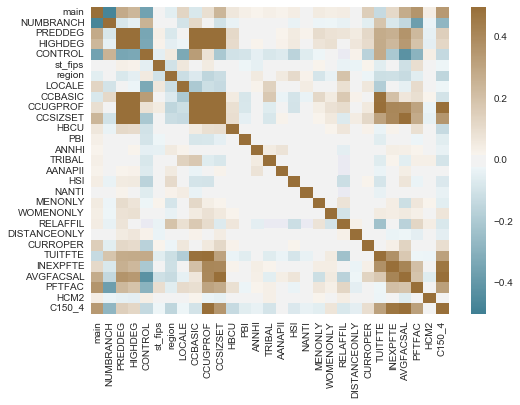

In [113]:
icorr = df_num.corr()
sns.heatmap(icorr, cmap=sns.diverging_palette(220, 50, as_cmap=True), vmax=.5)

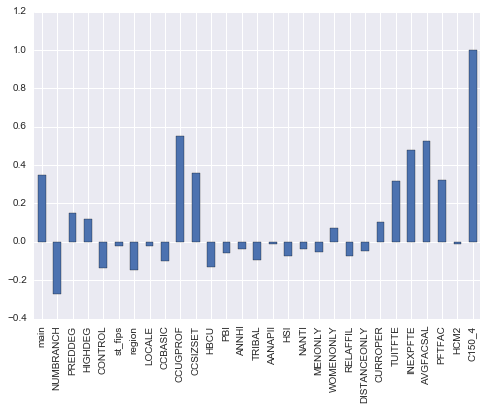

In [114]:
comp_corr_num = icorr['C150_4']
comp_corr_num.plot(kind='bar')